In [2]:
# Install required packages in the notebook environment if they're missing
%pip install torch torchvision matplotlib

from pathlib import Path
import json
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/111.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/111.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/111.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/111.0 MB 1.4 MB/s eta 0:01:19
    --------------------------------------- 1.6/111.0 MB 2.0 MB/s eta 0:00:54
    --------------------------------------- 2.1/111.0 MB 2.2 MB/s eta 0:00:51
    --------------------------------------- 2.6/111.0 MB 2.2 MB/s eta 0:00:50
   - -------------------------------------- 3.1/111.0 MB 2.3 MB/s eta 0:00:47
   - -------------------------------------- 3.4/111.0 MB 2.3 MB/s eta 0:00:48
   - -------------------------------------- 3.7/111.0 MB 2.2 MB/s eta 0:00:50
   - -------------------------------------- 4.2/111.0 MB 2.0 MB/s eta 0:00:53
   - ---------------------------------

In [3]:
processed_dir = Path("../data/processed/cxr")

train = processed_dir / "train"
val   = processed_dir / "val"
test  = processed_dir / "test"

In [4]:
"""
Data preparation for CNNs
- Raw images have different sizes (CNN needs fixed image size)
- Pixel values are between 0-255, but should scale to 0-1 for faster computation
- Convert all grayscale iamges to rgb since most pretrained CNN models use rgb
"""
train_transforms = transforms.Compose([
  transforms.Grayscale(num_output_channels=3),
  transforms.Resize((224, 224)), # most CNNs generally use 224x224 for images
  transforms.RandomHorizontalFlip(p=0.5), # data augmentation for training
  transforms.RandomRotation(degrees=5), # not all X-rays are snapped on at the same angle
  transforms.ToTensor(), # Converts PIL images to tensors which scales pixels between 0 and 1
  transforms.Normalize( # normalize using ImageNet stats for transfer learning
    mean=[0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
  )
])

eval_transforms = transforms.Compose([
  transforms.Grayscale(num_output_channels=3),
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
  )
])

In [5]:
"""
ImageFolder automatically loads image datasets in a speific folder structure by
assigning them integer labels based on classes, apply the transforms to preprocess
images by converting them to tensors and returns a Dataset object which is an iterable
that yields an (image tensor, label) tuple
"""
train_dataset = datasets.ImageFolder(train, transform=train_transforms)
val_dataset = datasets.ImageFolder(val, transform=eval_transforms)
test_dataset = datasets.ImageFolder(test, transform=eval_transforms)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))
print("Class to index mapping:", train_dataset.class_to_idx)
print("Classes list:", train_dataset.classes) 

Train samples: 4433
Val samples: 784
Test samples: 624
Class to index mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Classes list: ['NORMAL', 'PNEUMONIA']


In [6]:
"""
Create an artifact directory to hold all files consumed during ML process
"""
artifacts = Path("../artifacts")
artifacts.mkdir(parents=True, exist_ok=True)

classes = train_dataset.classes

# Converts classes into a json string and writes it to classes.json
(artifacts / "classes.json").write_text(json.dumps(classes, indent=2))
print("Saved classes:", classes)

Saved classes: ['NORMAL', 'PNEUMONIA']


In [7]:
"""
Creates an iterable object that can be looped through during training to get
batches of data
"""
train_loader = DataLoader(
  train_dataset,
  batch_size=32, # group 32 images into a single batch and update weights after processing each batch
  shuffle=True, # data is randomly reordered on every iteration through the dataset for more generalization
  num_workers=2, # pre-processing happens in parallel on the GPU
  pin_memory=True # transfer data samples from CPU to GPU memory when training on CUDA
)

val_loader = DataLoader(
  val_dataset,
  batch_size=32,
  shuffle=False,
  num_workers=2,
  pin_memory=True
)

test_loader = DataLoader(
  test_dataset,
  batch_size=32,
  shuffle=False,
  num_workers=2,
  pin_memory=True
)

In [8]:
"""
Check a batch to see an example output
"""
xb, yb = next(iter(train_loader))

print("xb shape:", xb.shape)
print("yb shape:", yb.shape)
print("xb dtype:", xb.dtype)
print("yb dtype:", yb.dtype)
print("Label examples:", yb[:10].tolist())

# xb = 32 images, 3 channels, height 244, weight 244
# yb = 32 labels

c:\Users\ericj\miniconda3\envs\cxr\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


xb shape: torch.Size([32, 3, 224, 224])
yb shape: torch.Size([32])
xb dtype: torch.float32
yb dtype: torch.int64
Label examples: [1, 1, 1, 1, 0, 1, 1, 1, 0, 0]


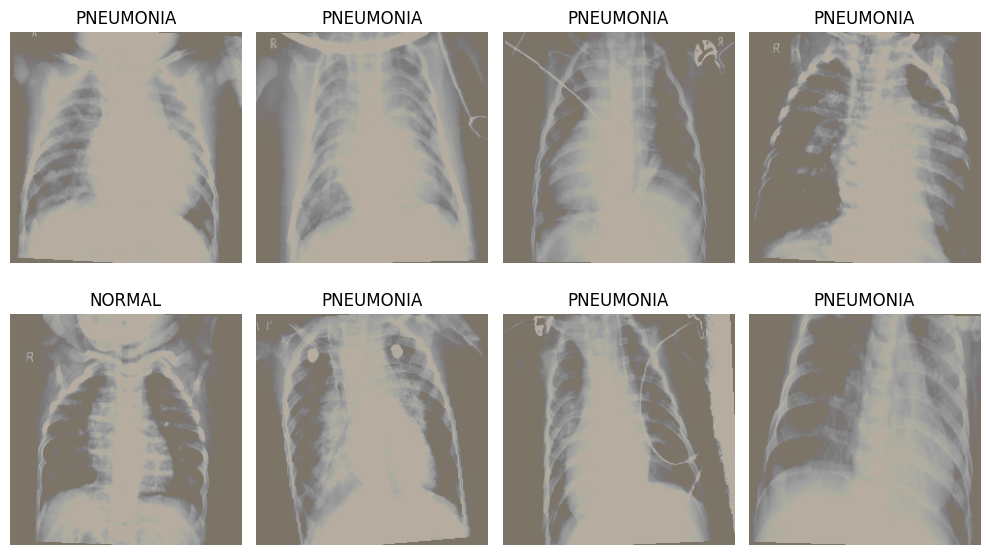

In [10]:
# unnormalize to plot images
def unnormalize(img_tensor):
  mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
  std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
  return img_tensor * std + mean # inverse of normalization formula

n = min(8, xb.shape[0])
plt.figure(figsize=(10, 6))

for i in range(n):
  img = unnormalize(xb[i].clamp(0, 1)) # convert a processed image tensor back to image format
  img_np = img.permute(1, 2, 0).numpy() # changes tensor shape for plotting [C,H,W] -> [H,W,C]

  # plt.subplot(3, 4, i+1)
  plt.subplot(2, 4, i+1)
  plt.imshow(img_np, cmap="gray")
  plt.title(classes[yb[i].item()])
  plt.axis("off")

plt.tight_layout()
plt.show()